In [252]:
import numpy as np
import pandas as pd
import statsmodels.api as sm 
import pylab as py 
from scipy.stats import skew
from scipy.stats import skewnorm
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.api as sm

In [275]:
# Import csv
df_meta = pd.DataFrame(pd.read_csv(r"C:\Users\agnes.wanwan\Desktop\ILS Use Case\Building Metadata.csv"))
df_train = pd.DataFrame(pd.read_csv(r"C:\Users\agnes.wanwan\Desktop\ILS Use Case\Training Data.csv"))
df_test = pd.DataFrame(pd.read_csv(r"C:\Users\agnes.wanwan\Desktop\ILS Use Case\Test Data.csv"))

print("Metadata: ")
# See properties in df_meta
#for col in df_meta.columns: print(col)
print(df_meta.columns)
df_meta.dtypes

print("\nTraining dataset: ")
# See properties in df_train
print(df_train.columns)
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])
df_train.dtypes

print("\nTest dataset: ")
df_test['timestamp'] = pd.to_datetime(df_train['timestamp'])
df_test.dtypes

Metadata: 
Index(['series_id', 'surface', 'base_temperature', 'monday_is_day_off',
       'tuesday_is_day_off', 'wednesday_is_day_off', 'thursday_is_day_off',
       'friday_is_day_off', 'saturday_is_day_off', 'sunday_is_day_off'],
      dtype='object')

Training dataset: 
Index(['series_id', 'timestamp', 'consumption', 'temperature'], dtype='object')

Test dataset: 


series_id               int64
timestamp      datetime64[ns]
consumption           float64
temperature           float64
dtype: object

In [276]:
# Generate days

# df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])

# df_train['date'] = df_train['timestamp'].dt.date
# df_train['year'] = df_train['timestamp'].dt.year
# df_train['month'] = df_train['timestamp'].dt.month
# df_train['day'] = df_train['timestamp'].dt.day
df_train['dayinweek'] = df_train['timestamp'].dt.dayofweek
df_test['dayinweek'] = df_train['timestamp'].dt.dayofweek

# Check day of week in English
# df_train['dayofweek'] = df_train['timestamp'].dt.day_name()

In [286]:
# Combining df_meta data with df_train

# Combine surface & base temp with df_train
tempdf = df_meta[['series_id', 'surface', 'base_temperature']]
df_train2 = pd.merge(df_train, tempdf, on = 'series_id', how = 'left')

# Check if date is day off
day_off_df = df_meta.melt('series_id', df_meta.filter(like = 'day_off').columns).rename(columns = {'variable':'dayinweek','value':'day_off'})
day_off_df['dayinweek'] = day_off_df['dayinweek'].map({'monday_is_day_off': 0,
                                                       'tuesday_is_day_off': 1,
                                                       'wednesday_is_day_off': 2,
                                                       'thursday_is_day_off': 3,
                                                       'friday_is_day_off': 4, 
                                                       'saturday_is_day_off': 5,
                                                       'sunday_is_day_off': 6})
df_train3 = pd.merge(df_train2, day_off_df, on = ['series_id', 'dayinweek'], how = 'left')
# df_train3['day_off'] = df_train3['day_off'].replace(np.nan, False)
# Converting true/false to binary
df_train3['day_off'] = df_train3['day_off'].replace(False, int(0)).replace(True, int(1))

# Arrange data in ascending order by series ID, then timestamp
df_train3 = (df_train3.assign(s = df_train3['series_id'],
                              t = df_train3['timestamp'])
         .sort_values(['s','t'], ascending = [True, True])
         .drop(['s','t'], axis = 1))
df_train3.reset_index(level=0, inplace=True)
# Convert binary numbers form float to integers
df_train3['day_off'] = df_train3['day_off'].astype(int)

df_train3

,index,series_id,timestamp,consumption,temperature,dayinweek,surface,base_temperature,day_off
0,143795,100003,2017-10-24 00:00:00,187969.954324,8.75,1,x-large,low,0
1,230804,100003,2017-10-24 01:00:00,191001.727781,8.70,1,x-large,low,0
2,339721,100003,2017-10-24 02:00:00,187969.954324,8.20,1,x-large,low,0
3,163563,100003,2017-10-24 03:00:00,187969.954324,7.75,1,x-large,low,0
4,19576,100003,2017-10-24 04:00:00,191001.727781,7.70,1,x-large,low,0
5,376018,100003,2017-10-24 05:00:00,191001.727781,7.60,1,x-large,low,0
6,289345,100003,2017-10-24 06:00:00,187969.954324,7.60,1,x-large,low,0
7,381499,100003,2017-10-24 07:00:00,251637.196918,8.05,1,x-large,low,0
8,326095,100003,2017-10-24 08:00:00,242541.876547,8.75,1,x-large,low,0
9,143796,100003,2017-10-24 09:00:00,281954.931486,10.05,1,x-large,low,0


In [278]:
# Combining df_meta data with df_train

# Combine surface & base temp with df_train
tempdf = df_meta[['series_id', 'surface', 'base_temperature']]
df_test = pd.merge(df_test, tempdf, on = 'series_id', how = 'left')

# Check if date is day off
day_off_df = df_meta.melt('series_id', df_meta.filter(like = 'day_off').columns).rename(columns = {'variable':'dayinweek','value':'day_off'})
day_off_df['dayinweek'] = day_off_df['dayinweek'].map({'monday_is_day_off': 0,
                                                       'tuesday_is_day_off': 1,
                                                       'wednesday_is_day_off': 2,
                                                       'thursday_is_day_off': 3,
                                                       'friday_is_day_off': 4, 
                                                       'saturday_is_day_off': 5,
                                                       'sunday_is_day_off': 6})
df_test = pd.merge(df_test, day_off_df, on = ['series_id', 'dayinweek'], how = 'left')
# df_test['day_off'] = df_test['day_off'].replace(np.nan, False)
# Converting true/false to binary
df_test['day_off'] = df_test['day_off'].replace(False, int(0)).replace(True, int(1))

# Arrange data in ascending order by series ID, then timestamp
df_test = (df_test.assign(s = df_test['series_id'],
                              t = df_test['timestamp'])
         .sort_values(['s','t'], ascending = [True, True])
         .drop(['s','t'], axis = 1))
df_test.reset_index(level=0, inplace=True)
# Convert binary numbers form float to integers
df_test['day_off'] = df_test['day_off'].astype(int)

df_test

,index,series_id,timestamp,consumption,temperature,dayinweek,surface,base_temperature,day_off
0,44219,100017,2013-01-15 21:00:00,30844.871694,19.000000,1,medium,low,0
1,46499,100017,2013-04-26 17:00:00,30987.787814,15.000000,4,medium,low,0
2,44710,100017,2013-05-06 16:00:00,30848.444597,7.666667,0,medium,low,0
3,42080,100017,2013-05-21 19:00:00,42510.400025,12.333333,1,medium,low,0
4,42081,100017,2013-07-01 08:00:00,31713.087126,11.000000,0,medium,low,0
5,42082,100017,2013-07-05 07:00:00,31245.036831,10.333333,4,medium,low,0
6,44498,100017,2013-07-08 23:00:00,40616.761429,11.333333,0,medium,low,0
7,43586,100017,2013-12-13 07:00:00,31227.172316,5.666667,4,medium,low,0
8,37871,100017,2014-03-03 22:00:00,31598.754229,9.000000,0,medium,low,0
9,34210,100017,2014-03-17 10:00:00,41699.351041,16.000000,0,medium,low,0


In [291]:
# # Get median temperature to fill in NA / NaN
df_train3['hour'] = df_train3['timestamp'].dt.hour
df_test['hour'] = df_test['timestamp'].dt.hour

# Get median temperature of each hour
med_tlow = pd.DataFrame(df_train3.loc[df_train3['base_temperature'] == 'low'].groupby(['hour'])['temperature'].median())
med_tlow['base_temperature'] = 'low'
med_thigh = pd.DataFrame(df_train3.loc[df_train3['base_temperature'] == 'high'].groupby(['hour'])['temperature'].median())
med_thigh['base_temperature'] = 'high'

# med_tlow.reset_index(level=0, inplace=True)
# med_thigh.reset_index(level=0, inplace=True)
# print(med_thigh)
med_thigh

,temperature,base_temperature
hour,,
0,20.583333,high
1,20.000000,high
2,19.925000,high
3,19.725000,high
4,19.475000,high
5,19.225000,high
6,19.000000,high
7,19.033333,high
8,20.200000,high


In [282]:
# Replace NA temperature with median values based on base temperature

df_train4 = df_train3
# df_train4['temperature'].fillna(df_train4['hour'].map(med_tlow.set_index('hour')['temperature']))
df_train4['temperature'] = df_train4['temperature'].fillna(pd.merge(df_train4, med_tlow, on=['hour','base_temperature'], how='left')['temperature_y'])
# print(df_train4.loc[df_train4.base_temperature == 'high'])
df_train4['temperature'] = df_train4['temperature'].fillna(pd.merge(df_train4, med_thigh, on=['hour','base_temperature'], how='left')['temperature_y'])

df_train4


df_test['temperature'] = df_test['temperature'].fillna(pd.merge(df_test, med_tlow, on=['hour','base_temperature'], how='left')['temperature_y'])
df_test['temperature'] = df_test['temperature'].fillna(pd.merge(df_test, med_thigh, on=['hour','base_temperature'], how='left')['temperature_y'])
df_test

,index,series_id,timestamp,consumption,temperature,dayinweek,surface,base_temperature,day_off,hour
0,44219,100017,2013-01-15 21:00:00,30844.871694,19.000000,1,medium,low,0,21
1,46499,100017,2013-04-26 17:00:00,30987.787814,15.000000,4,medium,low,0,17
2,44710,100017,2013-05-06 16:00:00,30848.444597,7.666667,0,medium,low,0,16
3,42080,100017,2013-05-21 19:00:00,42510.400025,12.333333,1,medium,low,0,19
4,42081,100017,2013-07-01 08:00:00,31713.087126,11.000000,0,medium,low,0,8
5,42082,100017,2013-07-05 07:00:00,31245.036831,10.333333,4,medium,low,0,7
6,44498,100017,2013-07-08 23:00:00,40616.761429,11.333333,0,medium,low,0,23
7,43586,100017,2013-12-13 07:00:00,31227.172316,5.666667,4,medium,low,0,7
8,37871,100017,2014-03-03 22:00:00,31598.754229,9.000000,0,medium,low,0,22
9,34210,100017,2014-03-17 10:00:00,41699.351041,16.000000,0,medium,low,0,10


,index,series_id,consumption,temperature,dayinweek,day_off,hour
index,1.000000,-3.528189e-04,0.000075,-0.002890,0.001735,-1.945115e-04,1.730208e-03
series_id,-0.000353,1.000000e+00,0.028052,-0.074664,0.000000,-7.536515e-03,-4.706917e-21
consumption,0.000075,2.805230e-02,1.000000,0.078014,-0.079554,-8.457262e-02,4.848955e-02
temperature,-0.002890,-7.466432e-02,0.078014,1.000000,-0.000249,-4.054582e-02,2.133868e-01
dayinweek,0.001735,0.000000e+00,-0.079554,-0.000249,1.000000,7.337779e-01,0.000000e+00
day_off,-0.000195,-7.536515e-03,-0.084573,-0.040546,0.733778,1.000000e+00,3.065368e-17
hour,0.001730,-4.706917e-21,0.048490,0.213387,0.000000,3.065368e-17,1.000000e+00


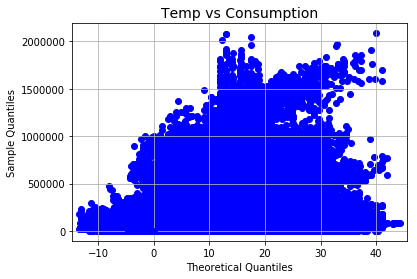

In [293]:
# EDA
# SOS Kai Wen

# Skewness
# skew_train = skew(df_train4['consumption'].dropna())
# print("Skewness: ", skew_train)

# fig, ax = plt.subplots(1, 1)
# mean, var, skew, kurt = skewnorm.stats(df_train4['consumption'], moments='mvsk')
# x = np.linspace(skewnorm.ppf(0.01, df_train4['consumption']),
#                 skewnorm.ppf(0.99, df_train4['consumption']), 100)
# ax.plot(x, skewnorm.pdf(x, a),
#        'r-', lw=5, alpha=0.6, label='skewnorm pdf')


# QQ Plot
sm.qqplot(df_train['temperature'])
# py.show()


# Scatter plot
plt.scatter(df_train4['temperature'], df_train4['consumption'], color='blue')
plt.title('Temp vs Consumption', fontsize=14)
plt.grid(True)
# plt.show()

df_train4.corr()


In [283]:
# Feature transformation
df_train5 = df_train4.drop(['index'], axis = 1)
df_train5['year'] = df_train5['timestamp'].dt.year
df_train5['month'] = df_train5['timestamp'].dt.month
df_train5['date'] = df_train5['timestamp'].dt.day
df_train5['minute'] = df_train5['timestamp'].dt.minute
df_train5['base_temperature'] = df_train5['base_temperature'].map({'low': 1,
                                                                    'high': 2})
# df_train5

df_test['year'] = df_test['timestamp'].dt.year
df_test['month'] = df_test['timestamp'].dt.month
df_test['date'] = df_test['timestamp'].dt.day
df_test['minute'] = df_test['timestamp'].dt.minute
df_test['base_temperature'] = df_test['base_temperature'].map({'low': 1,
                                                                    'high': 2})
# df_test

In [284]:
# Linear Regression?
# X = df_train5[['series_id', 'timestamp', 'temperature', 'base_temperature']]
X = df_train5[['series_id', 'temperature', 'year', 'month', 'date', 'hour', 'minute', 'base_temperature', 'day_off']]
Y = df_train5['consumption']

# X_predict = df_test[['series_id', 'timestamp', 'temperature', 'base_temperature']]
# y_predict = model.predict(X_predict)

regr = linear_model.LinearRegression()
regr.fit(X, Y)
print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# prediction with sklearn
regr.predict(df_test[['series_id', 'temperature', 'year', 'month', 'date', 'hour', 'minute', 'base_temperature', 'day_off']])

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()

Intercept: 
 -16727842.973504847
Coefficients: 
 [ 4.72284554e+00  1.84005313e+03  8.13543724e+03  4.67572538e+02
 -1.46745066e+02  7.84522401e+02  0.00000000e+00 -7.38043170e+04
 -3.28683753e+04]
